# Изучение закономерностей, определяющих успешность видео-игр

Нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.


In [129]:
import pandas as pd
import seaborn as sb 
import numpy as np 
import matplotlib.pyplot as plt #для функции show
import matplotlib.dates as mdates
from scipy import stats as st

In [130]:
data = pd.read_csv('/datasets/games.csv')

In [131]:
display(data.head())
data.info()

In [132]:
#приводим названия столбцов к нижнему регистру
data.columns = data.columns.str.lower()

In [133]:
#Проверим, есть ли здесь дубликаты
data.duplicated().sum()
#явных дубликатов нет

____
**Преобразуем данные в нужные типы**:

- Столбец user_score явно должен содержать численные значения, так как это оценка фильма. В дальнейшем анализе эти данные понадобятся нам именно как количественные.
- Столбец year_of_release содержит год выпуска игры, то есть целые значения. Заменим float на int64

In [134]:
data['year_of_release'] = data['year_of_release'].astype('Int64')

Посмотрим, что там с tbd. Эта аббревиатура расшифровывается как "to be determined" и означает, что по какой-то причине (например, недостаточно пользователей выставило оценку) оценка еще не подсчитана.

In [135]:
print(data.query('user_score == "tbd"')['platform'].unique())
print(data.query('user_score == "tbd"')['year_of_release'].unique())
#2324 всего, с разных годов, на разных платформах
print(len(data.query('user_score == "tbd"'))/len(data['platform'])*100)
#эти значения составляют 14% данных

Так как по сути для текущего анализа эти значения являются пропусками, заменим их на Nan.

In [136]:
data.replace(['tbd'], np.nan, inplace = True)

In [137]:
data.query('user_score == "tbd"')

In [138]:
data['user_score'] = pd.to_numeric(data['user_score']) #приводим user_score к численному типу

____
**Проведем обработку пропусков**
____

In [139]:
display(data.head())
print(data.isna().sum())
#Пропуски есть в Critic_score (8578), User_score (6701), Rating (6766), Year of release (269)
#Посмотрим на процентное соотношение пропусков ко всем данным
data.isna().sum()/len(data['platform'])*100

Пропуски в названии игры, годе выпуска игры и жанре составляют суммарно меньше 2% данных. Пока оставим их без изменений. 

А вот пропуски в оценке пользователей и критиков составляют почти половину данных.

Можно было бы заменить их на медианные значения по жанру и платформе, однако с учетом числа пропусков такая замена может исказить форму распределений и статистики данных и повлиять на дальнейший анализ.

Посмотрим внимательнее на то, как распределены эти пропуски по годам и жанрам.

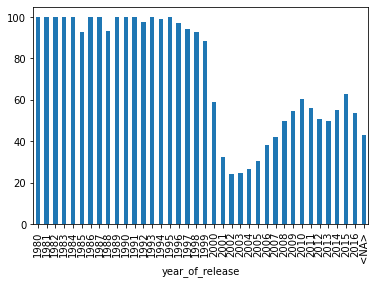

In [140]:
data['null_critic'] = data['critic_score'].isna()
to_plot = data.groupby(['year_of_release'], dropna = False)['null_critic'].sum()/data.groupby(['year_of_release'], dropna = False)['null_critic'].count()*100
to_plot.plot.bar()

Похоже, оценка критиков отсуствует у большинства игр до 2000 года (не меньше 88% пропусков). Посмотрим на оценку пользователей.

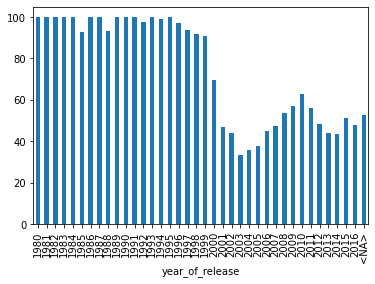

In [141]:
data['null_user'] = data['user_score'].isna()
to_plot = data.groupby(['year_of_release'], dropna = False)['null_user'].sum()/data.groupby(['year_of_release'], dropna = False)['null_user'].count()*100
to_plot.plot.bar()

Видим очень похожую ситуацию с оценками игроков - до 2000 года процент пропусков одинаковый. Видимо, данные об оценках игроков и критиков до 2000 года были подтянуты из одной базы и для игр этих годов система аггрегирования оценок была еще не вполне сформирована.

Посмотрим на распределение пропусков рейтинга игр по годам.

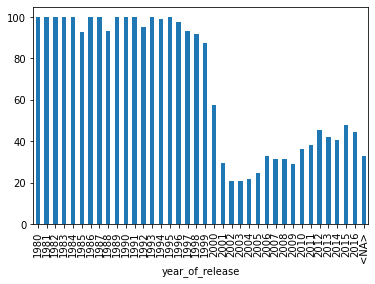

In [142]:
data['null_rating'] = data['rating'].isnull()
to_plot = data.groupby(['year_of_release'], dropna = False)['null_rating'].sum()/data.groupby(['year_of_release'], dropna = False)['null_rating'].count()*100
to_plot.plot.bar()

Наблюдаем ту же картину - до 2000 года почти у всех игр не выставлен рейтинг ESRB.

Похоже, до 2000 (или даже скорее до 2001, так как для 2000 пропуски составляют больше 50%) системы аггрегирования информации об оценках пользователей, критиков и рейтингах. Возможно, это связано с появлением в начале 2000-х таких сервисов как Steam (2002), упростивших процесс сбора этих данных в одном месте.

____
Теперь посмотрим на распределение пропусков по жанрам.

In [143]:
data.groupby(['genre'], dropna = False)['null_critic'].sum()/data.groupby(['genre'], dropna = False)['null_critic'].count()*100

In [144]:
data.groupby(['genre'], dropna = False)['null_user'].sum()/data.groupby(['genre'], dropna = False)['null_user'].count()*100

Выше всего процент пропусков оценок критиков у игр жанра adventure, misc и puzzle, возможно, сюда попадают маленькие инди-игры, не набирающие достаточно популярности. В оценках игроков выше всего процент пропусков в жанрах adventure, misc, fighting, role-playing и strategy.

**Гипотеза**: пропуски в оценках игроков, оценках критиков и рейтингов в играх после 2000 года чаще встречаются среди непопулярных игр (т.е. игры с низкими продажами).


------
**Подсчитаем суммарные продажи**

(в миллионах копий)

In [145]:
data['total_sales'] = abs(data['na_sales']) + abs(data['eu_sales']) + abs(data['jp_sales']) + abs(data['other_sales'])

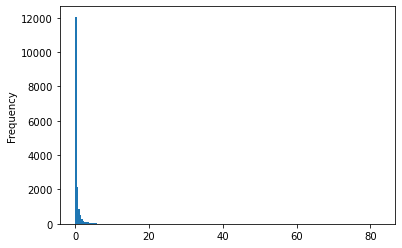

In [146]:
#посмотрим на распределение продаж в целом
data['total_sales'].plot.hist(bins = 200)
#поделим значения на 4 равные группы
print(pd.qcut(data['total_sales'], 4))
#добавим категории

In [147]:
def categ_sales(sales):
    try:
        if -0.001 <= sales <= 0.06:
            return 'low'
        elif 0.06 < sales <= 0.17:
            return 'mid_low'
        elif 0.17 < sales <= 0.47:
            return 'medium'
        elif 0.47 < sales:
            return 'high'
        else:
            return 'unknown'
    except:
        pass

In [148]:
data['total_sales_category'] = data['total_sales'].apply(categ_sales)

Посмотрим на процент пропусков по категориям продаж.

In [149]:
#оценки пользователей
data.groupby(['total_sales_category'], dropna = False)['null_user'].sum()/data.groupby(['total_sales_category'], dropna = False)['null_user'].count()*100

In [150]:
#оценки критиков
data.groupby(['total_sales_category'], dropna = False)['null_critic'].sum()/data.groupby(['total_sales_category'], dropna = False)['null_critic'].count()*100

In [151]:
#рейтинг игры
data.groupby(['total_sales_category'], dropna = False)['null_rating'].sum()/data.groupby(['total_sales_category'], dropna = False)['null_rating'].count()*100

Данные о процентах пропусков в разных категориях поддерживают нашу гипотезу - выше всего процент пропусков во всех трех столбцах у игр с продажами до 0.06 миллионов копий (т.е. меньше 60 тысяч, во всех трех столбцах процент пропусков выше 50), дальше идут игры с продажами от 60 до 170 тысяч (процент пропусков 38-53%), затем игры с продажами до 470 тысяч (35-47%), а ниже всего процент пропусков у игр с высокими продажами (29-35%). 

____
**Вывод по пропускам**:
Пропуски в столбцах user_score, critic_score и rating чаще встречаются до 2000-х годов и в группе игр с невысокими продажами. Вероятно, в 2000-х появились сервисы-аггрегаторы, которые упростили выставление и подсчет коллективных оценок аудитории и критиков. Пропуски также неравномерно распределены по жанрам, мы предполагаем, что игры в жанрах, нацеленные на менее массовое потребление, привлекают меньше внимания и получают меньше оценок.

На данном этапе оставим эти пропуски неизменными, возможно, данные о непопулярных играх и играх до 2000 года не понадобятся нам в статистическом анализе для маркетинговых целей.

Заполнение пропусков в столбцах user_score и critic_score медианными или средними значениями может привести к серьезному искажению формы распределения данных в связи с тем, какую большую долю составляют эти значения.

Пропуски в столбце rating заполним заглушкой "no rating".

In [152]:
data.loc[data['rating'].isna(), 'rating'] = 'no rating'

## Исследовательский анализ данных<br>


----
**Посмотрим, сколько игр выпускалось в разные годы.**

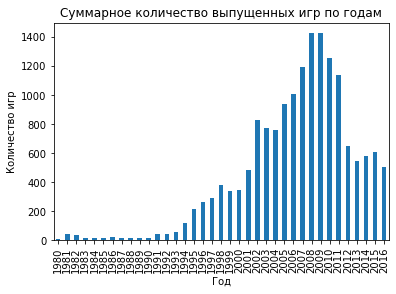

In [153]:
data.groupby('year_of_release')['name'].count().plot.bar(title = 'Суммарное количество выпущенных игр по годам')
plt.xlabel('Год')
plt.ylabel('Количество игр')
plt.show()

Судя по этим данным, до 2001 года игр выпускалось достаточно мало. Учитывая, что для маркетингового прогноза нам скорее всего более актуальны свежие данные, этот период нас не очень интересует. Более того, график показывает, что в индустрии компьютерных игр наблюдается резкий спад с 2011 года (плавный спад начинается еще в 2010 после пиковых 2008-2009 год). Можно предположить, что начавшийся рост "оборвался" кризисом 2008 года.

Также можно выдвинуть версию, что создание новых игр сократилось в связи с конкуренцией мобильных игр, которые больше соотвествовали финансовому поведению пользователей в кризисный период и в целом доступнее (см. https://www.statista.com/chart/915/consumer-spending-on-video-games-in-the-united-states/ и https://financialpost.com/technology/gaming/u-s-video-game-sales-drop-9-in-2012-despite-rise-in-digital-revenue). 

Посмотрим на суммарные продажи всех платформ за весь период данных, чтобы наметить перспективные платформы.

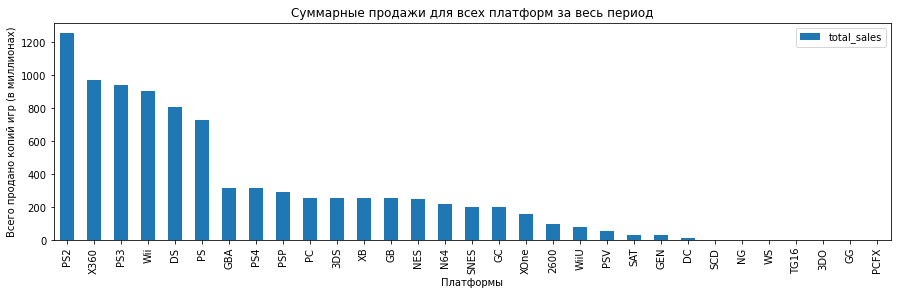

In [154]:
pivot_all_data_platform = data.pivot_table(index = 'platform', values = 'total_sales', aggfunc = 'sum')
pivot_all_data_platform.sort_values(by = 'total_sales', ascending = False).plot(kind = 'bar',figsize = (15,4), title = "Суммарные продажи для всех платформ за весь период")
plt.ylabel('Всего продано копий игр (в миллионах)')
plt.xlabel('Платформы')

Если смотреть на продажи на платформах за весь период, то вперед вырываются Play Station (особенно Play Station 2), Xbox (особенно Xbox 360) и Nintendo (DS и Wii). Дальше посмотрим, как продажи разных платформ этих компаний распредлены по годам.


**Посмотрим, как менялись продажи по платформам за весь период по годам.**

Выберем платформы с наибольшими суммарными продажами и построим распределение по годам. 
(*За какой характерный срок появляются новые и исчезают старые платформы?)*

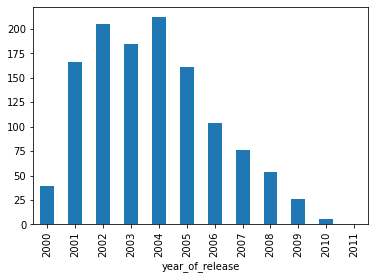

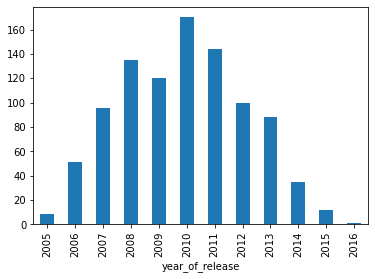

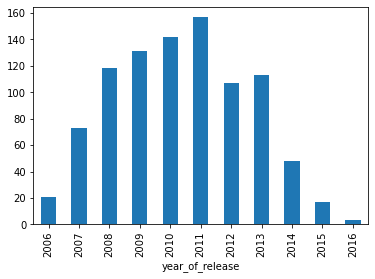

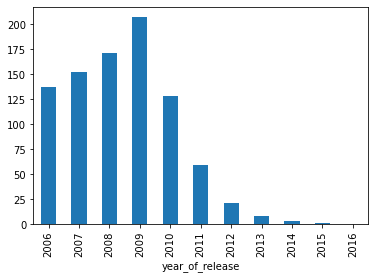

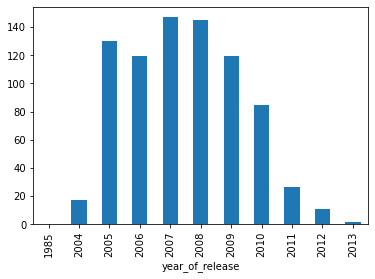

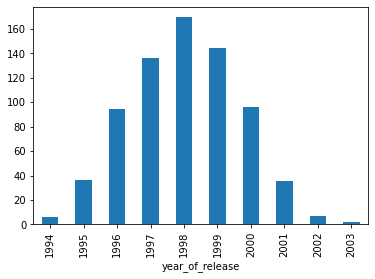

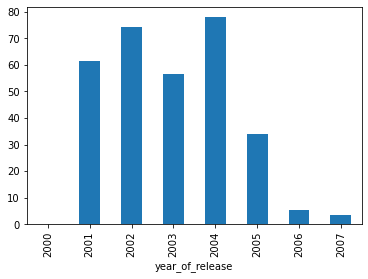

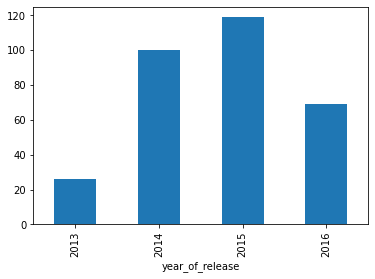

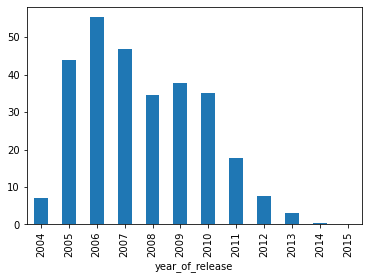

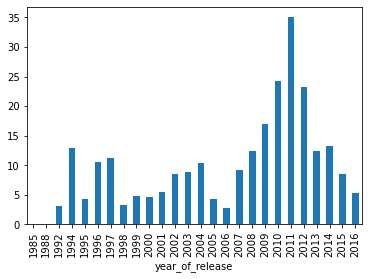

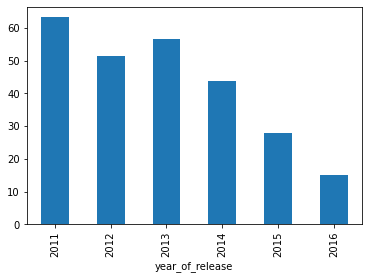

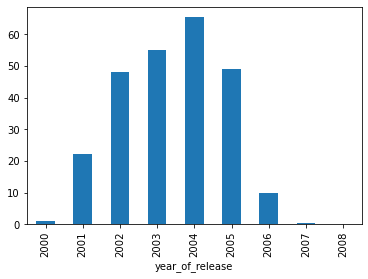

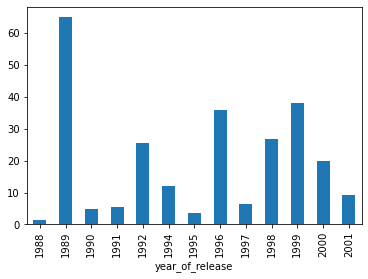

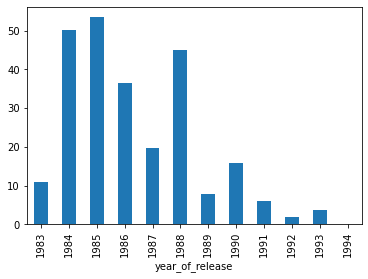

In [155]:
pop_platform = list(data.groupby('platform')['total_sales'].sum().sort_values(ascending = False).index[0:14])
#возьмем первые 14

for plat in pop_platform:
    data.query('platform == @plat').groupby('year_of_release')['total_sales'].sum().plot.bar()
    print('Распределение суммарных продаж по годам на плафторме', plat)
    print()
    
    plt.show()
    print('-----')
    print()

Мы видим, что в основном платформы "живут" около 10 лет (8-11): 

Play station - 1994-2003, PS 2 - 2000-2011, PS3 - 2006-2016 (PS4 - с 2013), PSP - 2004-2014 <br>
Wii - 2006 - 2016 (но к 2015 продажи снизились почти до 0) <br>
Xbox 360 - 2005-2016 <br>
Nintendo DS - 2004-2013 (1985 год - явно ошибка ввода данных) <br>
Xbox - 2000-2008 <br>
Nintendo Entertainment System (NES) - 1983-1994 <br>

  Исключение составляют платформа Game Boy Advance (GBA), которая прожила всего с 2001 по 2007, Game boy, которая продержалась целых 14 лет (1988-2001), Nintendo 3DS еще не прошедшая свой жизненный цикл (появилась в 2011) и, наконец, PC, то есть персональный компьютер, который строго говоря не является платформой (здесь можно было бы смотреть на игры под разные версии операционных систем).


------
**Возьмем данные за соответствующий актуальный период и посмотрим на потенциально прибыльные платформы**. 

Мы возьмем период с 2013 года, то есть примерный год начала цикла тех платформ, для которых 2017 будет пиковым годом (например, именно в 2013 стартовала платформа PS4). Это также позволит избежать искажения прогноза продажами тех платформ, чей пик пришелся на 2011-2013 и чей цикл практически завершился к 2016 году. Таким образом, мы возьмем для исследования период с 2013 по 2016 год.

In [156]:
recent_data = data[data['year_of_release'] >= 2013]

In [157]:
#посмотрим на лидеров продаж среди платформ
print(recent_data.groupby('platform')['total_sales'].sum().sort_values(ascending = False))
pop_platform = list(recent_data.groupby('platform')['total_sales'].sum().sort_values(ascending = False).index)

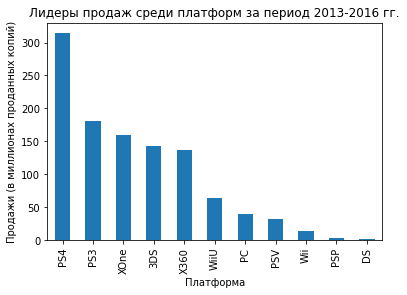

In [158]:
recent_data.groupby('platform')['total_sales'].sum().sort_values(ascending = False).plot.bar(title = 'Лидеры продаж среди платформ за период 2013-2016 гг.')
plt.xlabel('Платформа')
plt.ylabel('Продажи (в миллионах проданных копий)')
plt.show()


В лидерах этого периода Play station 4, Play station 3, Xbox One, Nintendo sDS и Xbox 360. Посмотрим, какие из этих платформ растут, а какие падают.

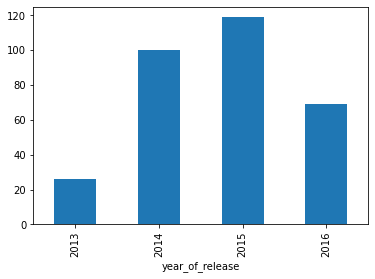

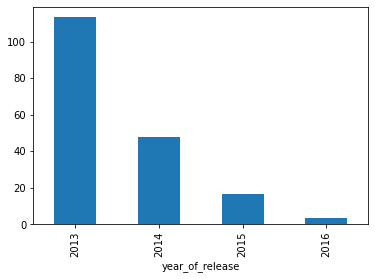

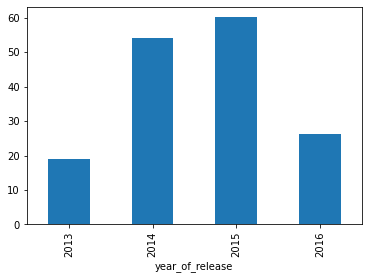

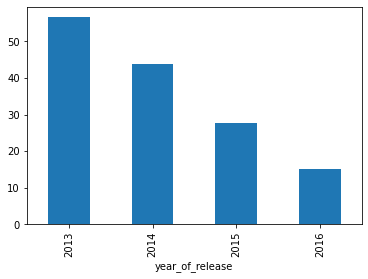

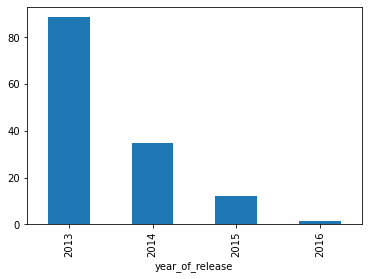

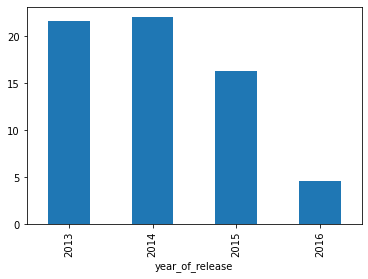

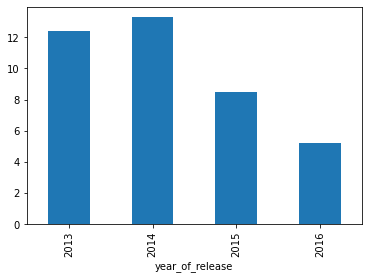

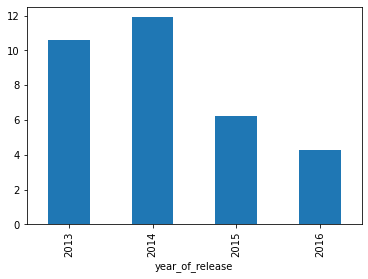

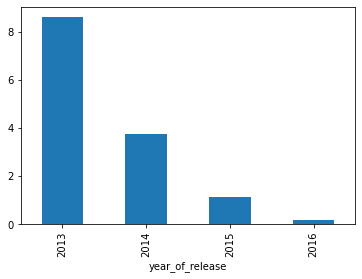

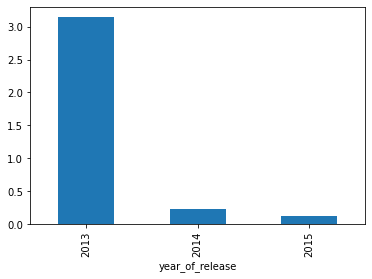

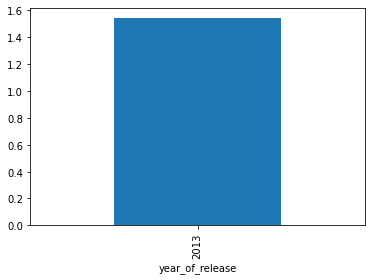

In [159]:
for plat in pop_platform:
    print('Распределение суммарных продаж по годам на плафторме', plat)
    print()
    try:
        recent_data.query('platform == @plat').groupby('year_of_release')['total_sales'].sum().plot.bar()
        plt.show()
        print('-----')
        print()
    except:
        print('что-то пошло не так')
    

Здесь мы видим продажи для всех платформ по отдельности, построим общий график.

In [160]:
pivot_pop_platform = recent_data.query('platform in @pop_platform').pivot_table(index = ('platform', 'year_of_release'), values = 'total_sales', aggfunc = 'sum')
pivot_pop_platform.reset_index(inplace = True)
pivot_pop_platform = pivot_pop_platform.pivot(index = 'year_of_release', columns = 'platform', values = 'total_sales')

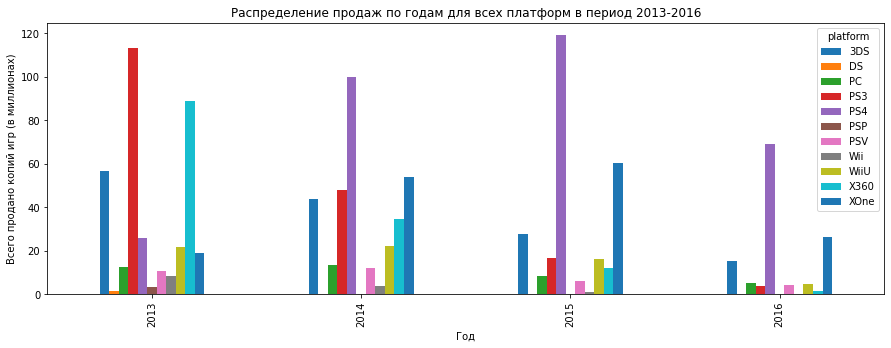

In [161]:
pivot_pop_platform.plot(kind = 'bar',figsize = (15,5), title = "Распределение продаж по годам для всех платформ в период 2013-2016")
plt.ylabel('Всего продано копий игр (в миллионах)')
plt.xlabel('Год')

Судя по распредлениям продаж по годам, падают практически все платформы, однако если учесть, что данные за 2016 год могут быть неполными, то самыми потенциально прибыльными будут Xbox One, Play Station 4, и Nintendo 3DS.

Построим график «ящик с усами» по глобальным продажам игр в разбивке по этим трем платформам.

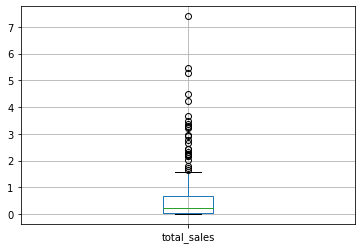

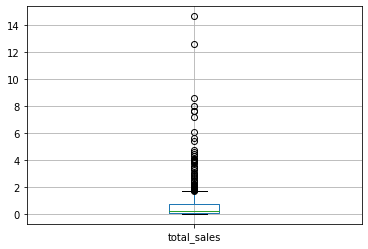

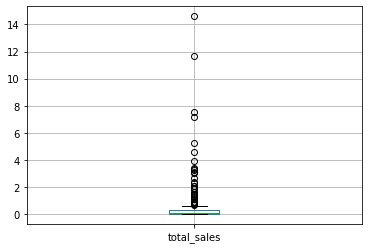

In [162]:
profit_platforms = ['XOne', 'PS4', '3DS']

for plat in profit_platforms:
    print('Ящик с усами для платформы', plat)
    recent_data.query('platform == @plat').boxplot(column = 'total_sales')
    plt.show()
    print('-----')
    print()
    

Графики для всех трех платформ показывают, что для средней игры на платформе продажы обычно не превышают 1 млн копий, однако у каждой платформы есть ряд игр-выбросов, продажи которых значительно превышают среднее (до 15 млн копий на Nintendo 3DS и Play Station 4 и до 8 на Xbob One)

Для удобства сравнения платформ, также построим общий график.

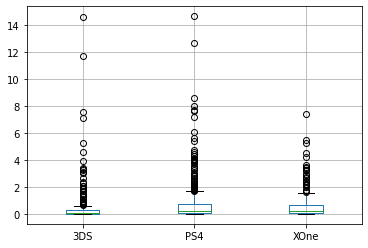

In [163]:
data_profit_platforms= recent_data.query('platform in @profit_platforms')[['platform', 'total_sales']]
ax = data_profit_platforms.pivot(columns = 'platform', values = 'total_sales').boxplot()
plt.show()

#Здесь мы хорошо видим выбросы, но не видим как следует медиану и разброс

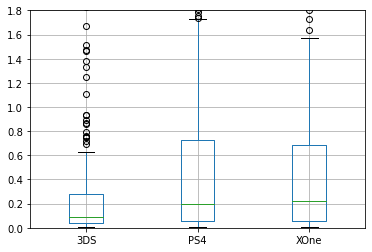

In [164]:
#Построим тот же график, по максимуму исключив выбросы
ax = data_profit_platforms.pivot(columns = 'platform', values = 'total_sales').boxplot()
ax.set_ylim(top=1.8, bottom = 0)
plt.show()

На графике без выбросов мы можем увидеть, что медианное значение проданных копий для платформ Play Station 4 и Xbox One практически равны между собой и равны примерно 0.2 миллиона проданных копий. Медианные продажи и 75% квартиль Nintendo 3DS ниже по сравнению с другими двумя платформами.


----
**Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков.**
Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами.

Возьмем платформу Play station 4 (PS4). Построим диаграмму рассеяния между оценками пользователей и продажами и подсчитаем корреляцию.

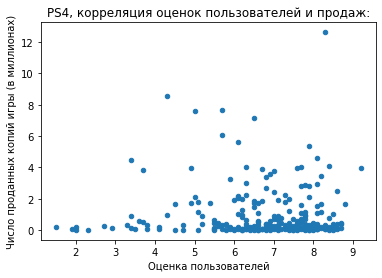

In [165]:

ps4 = recent_data.query('platform == "PS4"')
ps4 = ps4.dropna()
ps4.plot.scatter(x = 'user_score', y = 'total_sales',title = 'PS4, корреляция оценок пользователей и продаж:')
plt.ylabel('Число проданных копий игры (в миллионах)')
plt.xlabel('Оценка пользователей')
plt.show()

corr = st.pearsonr(x = ps4['user_score'], 
            y = ps4['total_sales'])

print('Коэффициент корреляции:', corr[0])
print( 'p-value:', corr[1], 'Значительно превышает порог значимости 0.05.')

Судя по графику и результатам анализа, корреляции между оценками пользователей и продажами нет.

Посмотрим на оценки критиков и продажи.

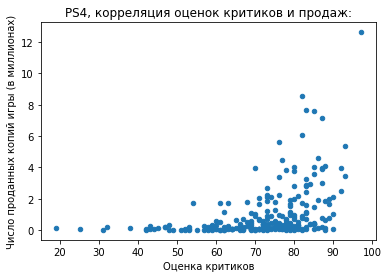

In [166]:
ps4.plot.scatter(x = 'critic_score', y = 'total_sales',title = 'PS4, корреляция оценок критиков и продаж:')
plt.ylabel('Число проданных копий игры (в миллионах)')
plt.xlabel('Оценка критиков')
plt.show()

corr = st.pearsonr(x = ps4['critic_score'], 
            y = ps4['total_sales'])

print('Коэффициент корреляции:', corr[0])
print( 'p-value:', corr[1], 'Ниже порога значимости 0.05.')

А вот с оценками критиков мы видим значимую умеренную (0.4) прямую корреляцию: чем выше оценки критиков, тем больше продажи игры. Таким образом, оценки критиков больше связаны с продажами игры, чем оценки пользователей на Play Station 4. Посмотрим, так ли это на двух других потенциально прибыльных платформах.

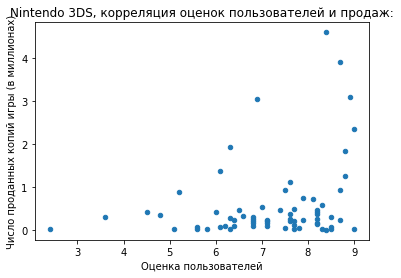

In [167]:
ds = recent_data.query('platform == "3DS"')
ds = ds.dropna()
ds.plot.scatter(x = 'user_score', y = 'total_sales',title = 'Nintendo 3DS, корреляция оценок пользователей и продаж:')
plt.ylabel('Число проданных копий игры (в миллионах)')
plt.xlabel('Оценка пользователей')
plt.show()

corr = st.pearsonr(x = ds['user_score'], 
            y = ds['total_sales'])

print('Коэффициент корреляции:', corr[0])
print( 'p-value:', corr[1], 'Не превышает порог значимости 0.05.')

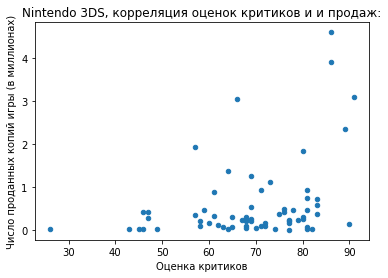

In [168]:
ds.plot.scatter(x = 'critic_score', y = 'total_sales',title = 'Nintendo 3DS, корреляция оценок критиков и и продаж:')
plt.ylabel('Число проданных копий игры (в миллионах)')
plt.xlabel('Оценка критиков')
plt.show()
corr = st.pearsonr(x = ds['critic_score'], 
            y = ds['total_sales'])


print('Коэффициент корреляции:', corr[0])
print( 'p-value:', corr[1], 'Не превышает порог значимости 0.05.')

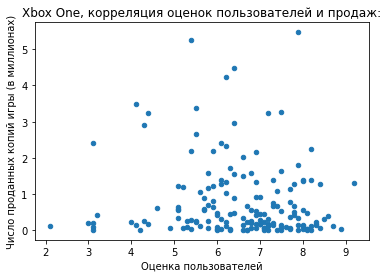

In [169]:
xb = recent_data.query('platform == "XOne"')
xb = xb.dropna()
xb.plot.scatter(x = 'user_score', y = 'total_sales',title = 'Xbox One, корреляция оценок пользователей и продаж:')
plt.ylabel('Число проданных копий игры (в миллионах)')
plt.xlabel('Оценка пользователей')
plt.show()
corr = st.pearsonr(x = xb['user_score'], 
            y = xb['total_sales'])

print('Коэффициент корреляции:', corr[0])
print( 'p-value:', corr[1], 'Превышает порог значимости 0.05.')

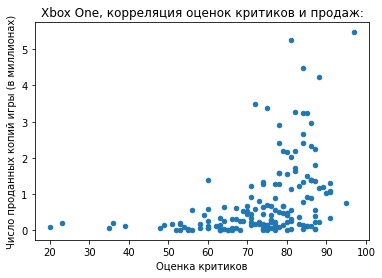

In [170]:
xb.plot.scatter(x = 'critic_score', y = 'total_sales',title = 'Xbox One, корреляция оценок критиков и продаж:')
plt.ylabel('Число проданных копий игры (в миллионах)')
plt.xlabel('Оценка критиков')
plt.show()

corr = st.pearsonr(x = xb['critic_score'], 
            y = xb['total_sales'])

print('Коэффициент корреляции:', corr[0])
print( 'p-value:', corr[1], 'Ниже порога значимости 0.05.')

**Выводы по корреляции продаж и оценок критиков и пользователей на платоформах Play Station 4, Nindendo 3DS и Xbox One**: На PS4 и Xbox One мы вижим схожие картины - значимая корреляция около 0.4 между оценками критиков и продажами и отсуствие значимых корреляций между оценками пользователей и продажами. Однако на Nintendo 3DS мы видим примерно одинаковую по размеру эффекта корреляцию продаж с оценками пользователей (0.27) и оценками критиков (0.35).

Для маркетингового прогноза более надежно будет как потенциальный указатель прибыльности оценку критиков.

----
----
**Посмотрим на распределениие игр по жанрам и их прибыльность**

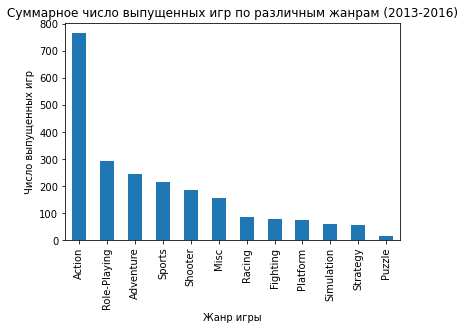

In [171]:
recent_data.groupby('genre')['name'].count().sort_values(ascending = False).plot.bar(title = 'Суммарное число выпущенных игр по различным жанрам (2013-2016)')
plt.ylabel('Число выпущенных игр')
plt.xlabel('Жанр игры')
plt.show()

Больше всего выпускается игр в жанре Action, за ним следуют Role-playing, Adventure, Sports и Shooter.
Посмотрим на продажи.

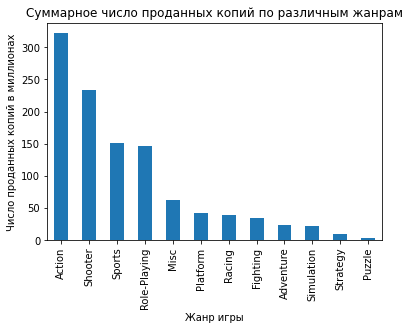

In [172]:
#суммарное число проданных копий
recent_data.groupby('genre')['total_sales'].sum().sort_values(ascending = False).plot.bar(title = 'Суммарное число проданных копий по различным жанрам')
plt.ylabel('Число проданных копий в миллионах')
plt.xlabel('Жанр игры')
plt.show()

Ожидаемо, выше всего суммарная прибыльность у жанра Action, однако мы также видим что здесь его догоняет Shooter, а Sports и Role-playing падают на 3 и 4 место.
Посмотрим на медианную прибыльность в расчете на игру.

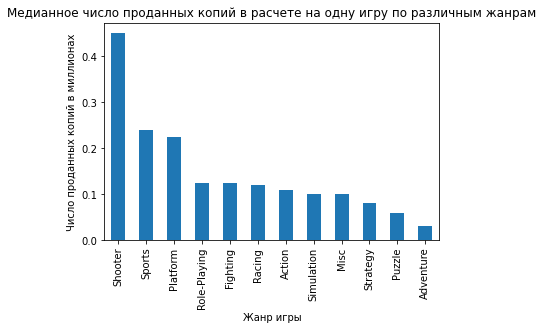

In [173]:
#прибыльность в расчете на одну игру
to_plot = recent_data.groupby('genre')['total_sales'].median().sort_values(ascending = False)
to_plot.plot.bar(title = 'Медианное число проданных копий в расчете на одну игру по различным жанрам')
plt.ylabel('Число проданных копий в миллионах')
plt.xlabel('Жанр игры')
plt.show()

**Выводы по прибыльности жанров:**
Столбчатая диаграмма медианной прибыльности на одной игры показывает, что здесь самым прибыльным жанром является Shooter, дальше идут Sports и Platform, а за ними примерно на одном уровне Racing, Role-playing, Fighting и Action.

Наименее прибыльными жанрами оказываются Adventure, Puzzle и Strategy.

## Составление портрета пользователя каждого региона<br>


**Посмотрим на самые популярные платформы для каждого региона**

In [174]:
# Здесь мы все еще используем датасет с актуальными данными (2013-2016)
region_platform = recent_data.pivot_table(index = 'platform', values = ['na_sales', 'eu_sales', 'jp_sales'], aggfunc = 'sum')
region_platform['na_ratio'] = region_platform['na_sales']/sum(region_platform['na_sales'])*100
region_platform['eu_ratio'] = region_platform['eu_sales']/sum(region_platform['eu_sales'])*100
region_platform['jp_ratio'] = region_platform['jp_sales']/sum(region_platform['jp_sales'])*100

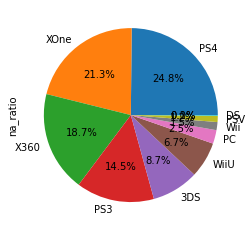

In [175]:
print("Топ 5 платформ для Северной Америки, доля от общих продаж")
print(region_platform['na_ratio'].sort_values(ascending = False)[0:5])
region_platform['na_ratio'].sort_values(ascending = False).plot(kind = 'pie', legend=False,
                   autopct='%1.1f%%')


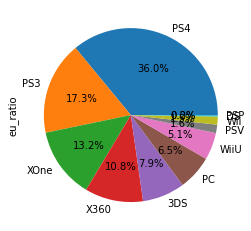

In [176]:
print("Топ 5 платформ для Европы, доля от общих продаж")
print(region_platform['eu_ratio'].sort_values(ascending = False)[0:5])
region_platform['eu_ratio'].sort_values(ascending = False).plot(kind = 'pie', legend=False,
                   autopct='%1.1f%%')

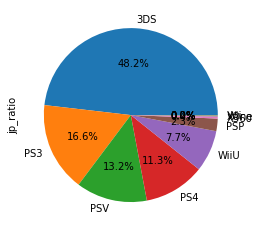

In [177]:
print("Топ 5 платформ для Японии, доля от общих продаж")
print(region_platform['jp_ratio'].sort_values(ascending = False)[0:5])
region_platform['jp_ratio'].sort_values(ascending = False).plot(kind = 'pie', legend=False,
                   autopct='%1.1f%%')

**Различия в долях продаж по платформам:** В Америке и Европе самой популярной является платформа Play Station 4, которая разрабатывается компанией Sony в Калифорнии, 24% продаж в Северной Америке и 35% продаж в Европе соотвественно. При этом в Европе на втором месте стоит Play Station 3 и только после нее идут Xbox One и Xbox 360, в то время как в Северной Америке платформы Xbox обгоняют Play Station 3. Как правило консоли Xbox дороже консолей Play Station, однако, возможно, это различие в цене особенно заметно в Европе, куда обе консоли импортируются.

В обоих регионах Nintendo на последнем месте. Зато в Японии *японская* же платформа Nintendo 3DS отвечает аж за 48% продаж, на 5 место попадает также разработанная Nintendo WiiU, 2-4 места достаются Play Station (причем у Play Station 4 продаж меньше, чем у Play Station 3), а дорогостоящий Xbox вообще не попал в топ. Можно также предположить, что на японских платформах выходит больше игр, заточенных под японских игроков, а на американских - под западных игроков.



-----
**Посмотрим на самые популярные жанры для каждого региона**

In [178]:
region_genre = recent_data.pivot_table(index = 'genre', values = ['na_sales', 'eu_sales', 'jp_sales'], aggfunc = 'sum')
region_genre['na_ratio'] = region_genre['na_sales']/sum(region_genre['na_sales'])*100
region_genre['eu_ratio'] = region_genre['eu_sales']/sum(region_genre['eu_sales'])*100
region_genre['jp_ratio'] = region_genre['jp_sales']/sum(region_genre['jp_sales'])*100

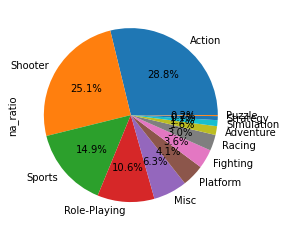

In [179]:
print("Топ 5 жанров для Северной Америки, доля от общих продаж")
print(region_genre['na_ratio'].sort_values(ascending = False)[0:5])
region_genre['na_ratio'].sort_values(ascending = False).plot(kind = 'pie', legend=False,
                   autopct='%1.1f%%')

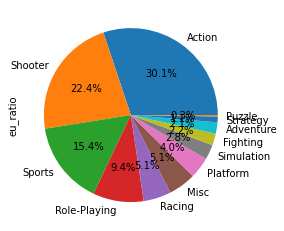

In [180]:
print("Топ 5 жанров для Европы, доля от общих продаж")
print(region_genre['eu_ratio'].sort_values(ascending = False)[0:5])
region_genre['eu_ratio'].sort_values(ascending = False).plot(kind = 'pie', legend=False,
                   autopct='%1.1f%%')

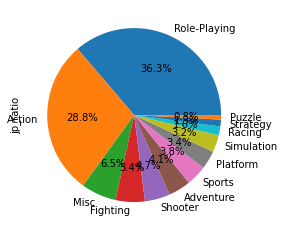

In [181]:
print("Топ 5 жанров для Японии, доля от общих продаж")
print(region_genre['jp_ratio'].sort_values(ascending = False)[0:5])
region_genre['jp_ratio'].sort_values(ascending = False).plot(kind = 'pie', legend=False,
                   autopct='%1.1f%%')

**Различия в долях продаж по жанрам:** В Америке и Европе мы видим очень схожую картину, самым популярным жанром является Action, дальше идут Shooter, Sports и Role-Playing, отличаются только последнии позиции топа. В Японии же на первое место вырывается жанр Role-Playing, а Action сдвигается на второе. Это можно объяснить культурными различиями, которых гораздо меньше между США и Европой, чем между этими регионами и Японией.


____
**Влияние рейтинга ESRB на продажи в отдельном регионе**

E - everyone, для всех возрастов<br>
E10+ - рекомендовано для людей не младше 10 лет<br>
T - teen, подростки, условно подходит для людей старше 13 лет<br>
M - mature, может содержать *всякое*, лучше не подходить раньше 17 лет<br>

In [182]:
region_rating = recent_data.pivot_table(index = 'rating', values = ['na_sales', 'eu_sales', 'jp_sales'], aggfunc = 'sum')
region_rating['na_ratio'] = region_rating['na_sales']/sum(region_rating['na_sales'])*100
region_rating['eu_ratio'] = region_rating['eu_sales']/sum(region_rating['eu_sales'])*100
region_rating['jp_ratio'] = region_rating['jp_sales']/sum(region_rating['jp_sales'])*100

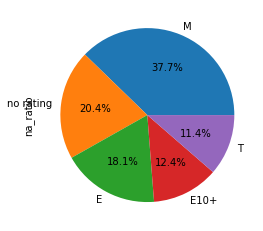

In [183]:
print("Продажи по рейтингам для Северной Америки, доля от общих продаж")
print(region_rating['na_ratio'].sort_values(ascending = False))
region_rating['na_ratio'].sort_values(ascending = False).plot(kind = 'pie', autopct='%1.1f%%')

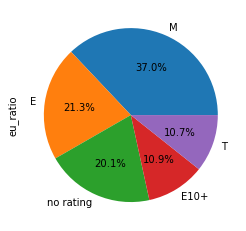

In [184]:
print("Продажи по рейтингам для Европы, доля от общих продаж")
print(region_rating['eu_ratio'].sort_values(ascending = False))
region_rating['eu_ratio'].sort_values(ascending = False).plot(kind = 'pie',autopct='%1.1f%%')

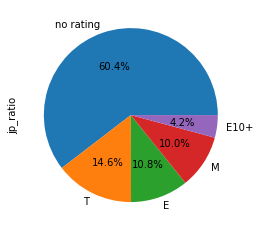

In [185]:
print("Продажи по рейтингам для Японии, доля от общих продаж")
print(region_rating['jp_ratio'].sort_values(ascending = False))
region_rating['jp_ratio'].sort_values(ascending = False).plot(kind = 'pie', autopct='%1.1f%%')

**Выводы по продажам по рейтингам в разных регионах**: Мы снова видим культурные различия - в Европе и Америке лучше всего продается более возрастной контент (с рейтингом M, отвечает почти за половину продаж). При этом в Америке на втором месте идут игры без рейтинга, затем контент для всех и только после него игры для детей 10+ и подростков. В Европе на втором месте игры для всех и на третьем - игры без рейтинга, однако разница между их долями всего 1%.

В Японии игры с рейтингом M занимают только 10% продаж, а на верху оказываются игры без рейтинга (они занимают целых 60%). Возможно, это связано с тем, что японские игроки предпочитают играть в японские игры, которые реже получают рейтинг ESRB (ведь компания базируется в США и Канаде). Различия в долях игр с рейтингом могут быть связаны с различным отношением к изображению насилия и секса в Японии и в западных регионах или, что также вероятно, со средним возрастом игроков. 


Быстрый поиск статей о различиях между геймерами и играми Японии и США показывает, что обе эти гипотезы имеют право на существование (например, https://www.gamedesigning.org/gaming/game-design-styles-japan-vs-west/ и https://www.academia.edu/37651569/Exploring_Cultural_Differences_in_Game_Reception_JRPGs_in_Germany_and_Japan , вторая статья также раскрывает причины популярности жанра Role-Playing в Японии)

## Проверка основных гипотезы исследования<br>
- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
- Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

**Проверка первой гипотезы**

H_0: Средние пользовательские рейтинги Xbox One = Средние пользовательские рейтинги PC. <br>
H_1: Средние пользовательские рейтинги Xbox One ≠ Средние пользовательские рейтинги платформ PC (двусторонняя гипотеза).


In [186]:
print(recent_data.isna().sum()/len(recent_data['name'])*100)
an_data = recent_data.dropna()

In [187]:
results = st.ttest_ind(
    an_data[an_data['platform'] =='XOne']['user_score'],
    an_data[an_data['platform'] =='PC']['user_score'],
    equal_var = False)

# alpha = задайте значение уровня значимости
alpha = 0.05

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Таким образом, мы можем сделать вывод, что оценки пользователей для Xbox One и PC не различаются, то есть наша изначальная гипотеза подтвердилась (не была опровергнута).

-----
**Проверка второй гипотезы**

H_0: Средние пользовательские рейтинги Action = Средние пользовательские рейтинги Sports. <br>
H_1: Средние пользовательские рейтинги Action ≠ Средние пользовательские рейтинги Sports (двусторонняя гипотеза).


In [188]:
results = st.ttest_ind(
    an_data[an_data['genre'] =='Action']['user_score'],
    an_data[an_data['genre'] =='Sports']['user_score'],
    equal_var = False)

# alpha = задайте значение уровня значимости
alpha = 0.05

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

В данном случае p-значение нашего теста оказалось меньше порогового значения, то есть между рейтингами жанров Action и Sports дейсвительно есть различия.

## Общий вывод

Основной задачей данного исследования было выявить определяющие успешность игры закономерности, которые позволили бы сделать ставку на потенциально популярный продукт и спланировать рекламные кампании. 

Наши рекомендации отделу маркетинга:



- У игры больше шансов стать полуряной, если она выходит на "живой" платформе - то есть платформе с высокими продажами в последние 2 года. 
- Также популярность игры связана с высокой оценкой критиков - именно у нее самая высокая корреляция (около 0.4 для трех ключевых платформ) с продажами для трех самых популярных платформ последних лет. При этом высокая оценка пользователей не гарантирует популярность игры - корреляция с продажами оказалась значима только для игроков Nintendo 3DS (Возможно, это как-то связано с различиями в культуре выставления оценок между Японией и западными регионами)
- Важно планировать различные рекламные компании в зависимости от региона - в Северной Америке и Европе имеет смысл делать ставку на игры американских платформ жанра Action, Shooter и Sports. В Японии более популярны японские платформы и игры в жанре Role-Playing (РПГ).
- Также важно учитывать рейтинг игры для региона, если в Северной Америке и Европе можно делать ставку на более взрослые игры, то в Японии лучше ориентироваться на игры без рейтинга - возможно, стоит сфокусироваться на играх японских компаний.
